<h2 style="color: blue; border-bottom: 2px solid black;">&#128187; Import Essential Libraries</h2>

<p style="font-size: 16px;">
    We start by importing essential Python libraries such as 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">os</span> 
    for <span style="font-weight: bold;">operating system</span> dependent functionalities and 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">pandas</span> 
    for <span style="font-weight: bold;">data manipulation</span>.
</p>


In [1]:
import os
import pandas as pd

<h2 style="color: blue; border-bottom: 2px solid black;">&#128293; Initialize PySpark Configuration</h2>

<p style="font-size: 16px;">
    Here, we initialize the 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">Spark Configuration</span> 
    and 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">Context</span>. 
    This is a <span style="font-weight: bold;">necessary step</span> before performing any Spark operations.
</p>


In [2]:
from pyspark import SparkConf, SparkContext

# Initialize SparkConf and SparkContext
conf = SparkConf().setAppName("SparkBinaryClassification").setMaster("local[*]")  # Adjust the parameters as needed
sc = SparkContext(conf=conf)

# Set log level
sc.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/28 20:44:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/28 20:44:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<h2 style="color: blue; border-bottom: 2px solid black;">&#128188; Import PySpark and Initialize</h2>

<p style="font-size: 16px;">
    In this cell, we import the 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">PySpark</span> 
    library and initialize the 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">Spark Session</span>.
</p>


In [3]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

# sc = pyspark.SparkContext(appName="imbalanced_binary_classification")
# initiate our session and read the main CSV file, then we print the #dataframe schema
spark = SparkSession.builder.appName('imbalanced_binary_classification').getOrCreate()
  

new_df = spark.read.csv('Datasets/application_train.csv', header=True, inferSchema=True)
new_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

<h2 style="color: blue; border-bottom: 2px solid black;">&#128193; Data Preprocessing: Dropping Columns</h2>

<p style="font-size: 16px;">
    In this section, we drop columns that are not needed for our analysis. 
    Here, we drop the 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">SK_ID_CURR</span> 
    column.
</p>


In [4]:
drop_col = ['SK_ID_CURR']
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])
new_df = new_df.withColumnRenamed('TARGET', 'label')
new_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


<h2 style="color: blue; border-bottom: 2px solid black;">&#128202; Exploring Target Distribution</h2>

<p style="font-size: 16px;">
    We visualize the distribution of our target variable to understand the 
    <span style="font-weight: bold;">class imbalance</span>, if any.
</p>


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


307511


<AxesSubplot: xlabel='label', ylabel='count'>

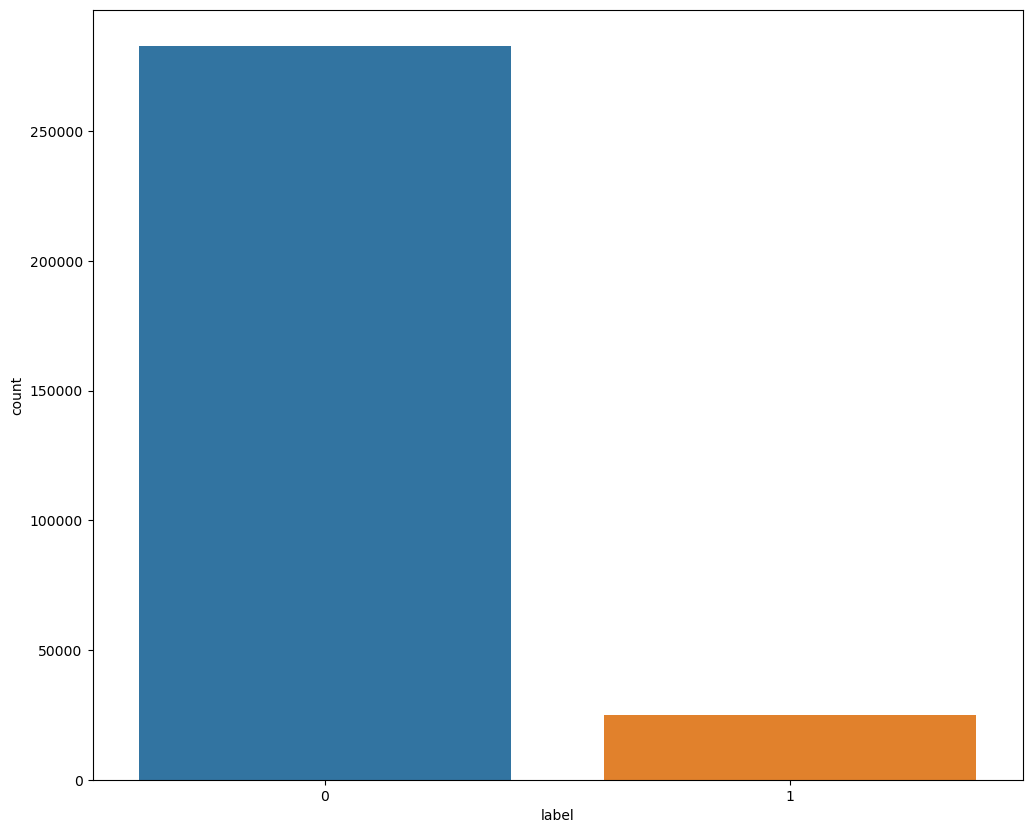

In [5]:
# let's have a look at the distribution of our target variable:
# to make it look better, we first convert our spark df to a Pandas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = new_df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)


<h2 style="color: blue; border-bottom: 2px solid black;">&#128202; Data Overview with Pandas</h2>

<p style="font-size: 16px;">
    We take a look at the data using 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">Pandas</span> 
    for a quick exploration. This helps in understanding the data before diving deeper into analysis.
</p>


In [6]:
# let's see how everything look in Pandas
import pandas as pd
pd.DataFrame(new_df.take(10), columns= new_df.columns)


,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


<h2 style="color: blue; border-bottom: 2px solid black;">&#128269; Categorical and Numerical Column Exploration</h2>

<p style="font-size: 16px;">
    In this cell, we explore the 
    <span style="font-weight: bold;">categorical</span> 
    and 
    <span style="font-weight: bold;">numerical</span> 
    columns in the dataset. This helps us understand the nature of each feature and plan for necessary preprocessing steps.
</p>


In [7]:
## [Categorical and Numerical column] ##

# See how many categorical + numerical features:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

print(str(len(cat_cols)) + '  categorical features')
print(str(len(num_cols)) + '  numerical features')


16  categorical features
104  numerical features


<h2 style="color: blue; border-bottom: 2px solid black;">&#128683; Handling Missing Values</h2>

<p style="font-size: 16px;">
    We investigate missing values in the dataset. Understanding the extent of missing values is 
    <span style="font-weight: bold;">crucial</span> 
    for effective data preprocessing and modeling.
</p>


In [8]:
## [Missing Values] ##

# we use the below function to find more information about the #missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns
missings = info_missing_table(df_pd)
missings


Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


<h2 style="color: blue; border-bottom: 2px solid black;">&#128187; Function to Count Missing Values</h2>

<p style="font-size: 16px;">
    This custom function counts the missing values for each column in the 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">Spark DataFrame</span>. 
    It's a <span style="font-weight: bold;">utility function</span> that we'll use later.
</p>


In [9]:
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts


<h2 style="color: blue; border-bottom: 2px solid black;">&#128200; Counting Missing Values in DataFrame</h2>

<p style="font-size: 16px;">
    Using the custom function we defined earlier, we count the missing values in each column of the 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">DataFrame</span>. 
    This helps us decide how to handle them in the preprocessing steps.
</p>


In [10]:
miss_counts = count_missings(new_df)
miss_counts


[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

In [11]:
# Separate categorical and numerical columns with missing values based on types

list_cols_miss=[x[0] for x in miss_counts]
df_miss= new_df.select(*list_cols_miss)

# categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("cateogrical columns_miss:", catcolums_miss)

# numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numerical columns_miss:", numcolumns_miss)

cateogrical columns_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
numerical columns_miss: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRA

<h2 style="color: blue; border-bottom: 2px solid black;">&#128295; Data Preprocessing: Filling Missing Values</h2>

<p style="font-size: 16px;">
    We fill the missing values in numerical columns with the 
    <span style="font-weight: bold;">median</span> 
    of the column. This is one strategy to handle missing data.
</p>


In [12]:
# (1) categorical --> the most frequent category

from pyspark.sql.functions import rank,sum,col
df_Nomiss=new_df.na.drop()
for x in catcolums_miss:                  
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's most categories 
    new_df = new_df.na.fill({x:mode})


NAME_TYPE_SUITE Unaccompanied


OCCUPATION_TYPE Laborers


FONDKAPREMONT_MODE reg oper account


HOUSETYPE_MODE block of flats


WALLSMATERIAL_MODE Panel


EMERGENCYSTATE_MODE No


In [13]:
# (2) numerical --> average value of each column

from pyspark.sql.functions import mean, round
for i in numcolumns_miss:
    meanvalue = new_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    new_df=new_df.na.fill({i:meanvalue})

AMT_ANNUITY 27109.0
AMT_GOODS_PRICE 538396.0
OWN_CAR_AGE 12.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 1.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 1.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0
COMMONAREA_MEDI 0.0
ELEVATORS_MEDI 0.0
ENTRANCES_MEDI 0.0
FLOORSMAX_MEDI 0.0
FLOORSMIN_MEDI 0.0
LANDAREA_MEDI 0.0
LIVINGAPARTMENTS_MEDI 0.0
LIVINGAREA_MEDI 0.0
NONLIVING

<!-- Data Preprocessing: Filling Missing Values -->
<h2 style="color: blue; border-bottom: 2px solid black;">&#128295; Data Preprocessing: Filling Missing Values</h2>

<p style="font-size: 16px;">
    We fill the missing values in numerical columns with the 
    <span style="font-weight: bold;">median</span> 
    of the column. This is one strategy to handle missing data.
</p>

<!-- Weight Balancing for Classes -->
<h2 style="color: blue; border-bottom: 2px solid black;">&#9879; Weight Balancing for Classes</h2>

<p style="font-size: 16px;">
    To handle class imbalance, we add a new column 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">weights</span> 
    to the DataFrame. We calculate the weight for each class to balance them.
</p>


In [14]:
# adding the new column weights and fill it with ratios
from pyspark.sql.functions import when
ratio = 0.91
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))
new_df = new_df.withColumn('weights', weight_balance(col('label')))


In [15]:
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.09
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,0.09
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.09
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09


<h2 style="color: blue; border-bottom: 2px solid black;">&#128288; String Indexing for Categorical Columns</h2>

<p style="font-size: 16px;">
    Before feeding the data into a machine learning model, we need to convert categorical features into a format that can be provided to machine learning algorithms. We use 
    <span style="font-weight: bold;">String Indexing</span> 
    for this purpose.
</p>


In [16]:
# we use the OneHotEncoderEstimator from MLlib in spark to convert #aech v=categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot ector #and the rest of numerical features into a 
# single vector column. we append every step of the process in a #stages array
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


<h2 style="color: blue; border-bottom: 2px solid black;">&#9881; Feature Engineering: Assembling Vectors</h2>

<p style="font-size: 16px;">
    We assemble all the feature columns into a single 
    <span style="font-family: 'Courier New'; background-color: #f2f2f2;">vector column</span>. 
    This is a required step before feeding the data into a Spark ML algorithm.
</p>


In [17]:
from pyspark.ml import Pipeline
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)


In [18]:
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)

# New dataset after feature engineering:
pd.DataFrame(new_df.take(5), columns=new_df.columns)


,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09


<h2 style="color: blue; border-bottom: 2px solid black;">&#128170; Train-Test Split</h2>

<p style="font-size: 16px;">
    We split the dataset into 
    <span style="font-weight: bold;">training</span> 
    and 
    <span style="font-weight: bold;">testing</span> 
    sets. This allows us to train the model on one subset and test it on another to evaluate its performance.
</p>

In [19]:
# split the data into trainign and testin sets
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

246475


61036


<h2 style="color: blue; border-bottom: 2px solid black;">&#128187; Model Training: Logistic Regression</h2>

<p style="font-size: 16px;">
    We train a 
    <span style="font-weight: bold;">Logistic Regression</span> 
    model using the training set. Logistic Regression is a good starting point for classification tasks.
</p>


In [20]:
# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

<h2 style="color: blue; border-bottom: 2px solid black;">&#128640; Model Evaluation</h2>

<p style="font-size: 16px;">
    After training the model, we evaluate its performance on the test set. We look at metrics like 
    <span style="font-weight: bold;">accuracy</span>, 
    <span style="font-weight: bold;">precision</span>, 
    <span style="font-weight: bold;">recall</span>, 
    and 
    <span style="font-weight: bold;">F1-score</span> 
    to understand how well the model is doing.
</p>


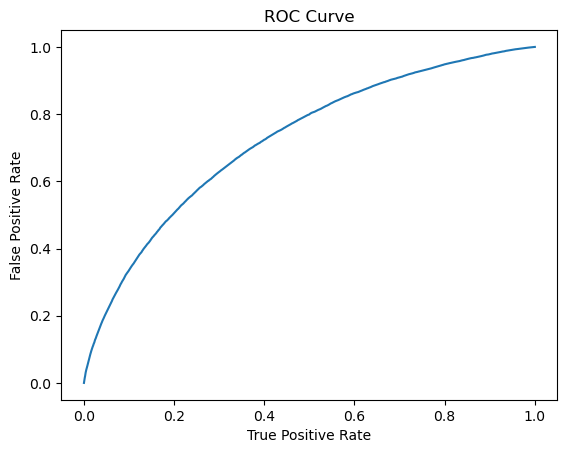

Training set ROC: 0.7240485115030597


In [21]:
#plotting the ROC Curve
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test SET ROC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))


Test SET ROC: 0.7172403283941673


In [23]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()

In [24]:
print("Test SET ROC: " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test SET ROC: 0.7294311382012976


/home/ehsan/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


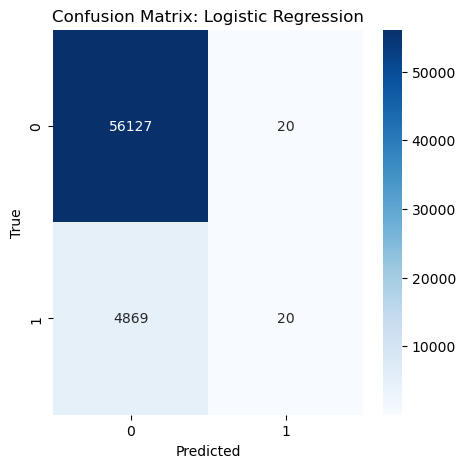

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics

def plot_confusion_matrix(predictions, model_name):
    prediction_and_labels = predictions.select("prediction", "label").rdd.map(tuple)
    metrics = MulticlassMetrics(prediction_and_labels)
    cm = metrics.confusionMatrix().toArray()
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

from pyspark.sql.functions import col
LR_predictions = LR_model.transform(test)
LR_predictions = LR_predictions.withColumn("label", col("label").cast("double"))
LR_predictions = LR_predictions.withColumn("prediction", col("prediction").cast("double"))


# For Logistic Regression
plot_confusion_matrix(LR_predictions, "Logistic Regression")